<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-4/4th_custom_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **4th File: LR schedule & Gradient Clipping**
    - Custom Loss Function

In [0]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null

In [0]:
import pandas as pd
import numpy as np
import time
import gc
import os
import sys
import dill
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
import warnings
from data_science_utils.vision.keras import *
from keras.layers import Activation
warnings.filterwarnings("ignore")
%matplotlib inline
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import SGD, Nadam, Adam

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:

X_train, Y_train, X_test, Y_test = get_mnist_data()
print(X_train.shape)
print(X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


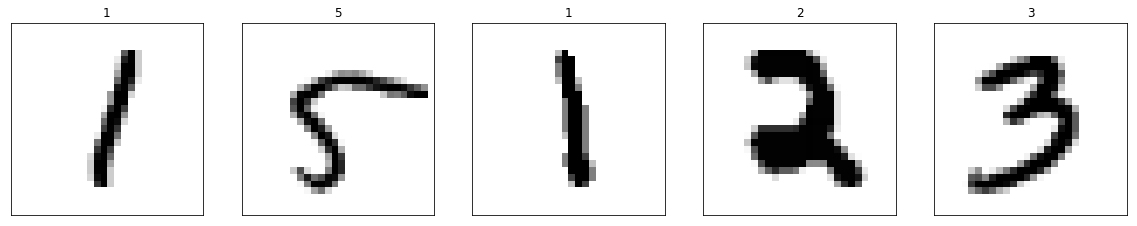

In [5]:
show_examples(X_train[10:15], Y_train[10:15],classes=get_mnist_labels())

## Defining a new Loss Fn


In [90]:
import tensorflow as tf
sess = K.get_session()
layer = model.layers[0]
weights = layer.get_weights()[0]
weights.shape
print()
# weights[:,:,:,0]
print()
wf1 = weights[:,:,:,0].reshape((9))
mf1 = wf1.mean()
wfmf1 = wf1-mf1

wf2 = weights[:,:,:,1].reshape((9))
mf2 = wf2.mean()
wfmf2 = wf2-mf2
print()
# np.matmul(wfmf1,wfmf2)
# np.std(wf1)*np.std(wf2)
print()

# a=weights.reshape((3,3,8)).reshape((-1,8)).T
b=weights.reshape((3,3,8)).reshape((-1,8))
b.shape
# am = a.mean(axis=1)
print()
bm = b.mean(axis=0)
bstd = b.std(axis=0)

# a-am
bbm = b-bm
print()
covmar = np.matmul(bbm.T,bbm)
bstd = bstd.reshape((8,1))
stdmar = np.matmul(bstd,bstd.T)

np.divide(covmar,stdmar)/9
print()
import tensorflow_probability as tfp
corr_matrix = tfp.stats.correlation(b, sample_axis=0, event_axis=-1)
sess.run(corr_matrix)
# stdmar

(3, 3, 1, 8)

(9, 8)

array([[ 1.        ,  0.2862468 ,  0.49597847,  0.6476801 ,  0.09925693,
        -0.30541795, -0.39901775, -0.06220487],
       [ 0.2862468 ,  0.9999999 , -0.31206903, -0.33442757,  0.7922114 ,
        -0.20678304, -0.04435635,  0.54701436],
       [ 0.49597847, -0.31206903,  1.        ,  0.6875251 , -0.4219026 ,
         0.20631473, -0.3282193 , -0.33180743],
       [ 0.6476801 , -0.33442757,  0.6875251 ,  1.        , -0.45093086,
        -0.11351078, -0.4397256 , -0.40469635],
       [ 0.09925693,  0.7922114 , -0.4219026 , -0.45093086,  1.        ,
         0.06862124,  0.20534825,  0.2623858 ],
       [-0.30541795, -0.20678304,  0.20631473, -0.11351078,  0.06862124,
         1.        ,  0.44719252,  0.06060467],
       [-0.39901775, -0.04435635, -0.3282193 , -0.4397256 ,  0.20534825,
         0.44719252,  1.        ,  0.4686712 ],
       [-0.06220487,  0.54701436, -0.33180743, -0.40469635,  0.2623858 ,
         0.06060467,  0.4686712 ,  0.9999999 ]], dtype=float32)

array([[ 1.        ,  0.28624687,  0.49597847,  0.64768016,  0.09925693,
        -0.30541798, -0.3990177 , -0.06220484],
       [ 0.28624687,  0.9999999 , -0.31206906, -0.33442762,  0.79221153,
        -0.20678309, -0.04435633,  0.5470144 ],
       [ 0.49597847, -0.31206906,  1.        ,  0.68752515, -0.42190254,
         0.20631476, -0.3282193 , -0.33180746],
       [ 0.64768016, -0.33442762,  0.68752515,  0.9999999 , -0.45093095,
        -0.11351077, -0.43972558, -0.40469632],
       [ 0.09925693,  0.79221153, -0.42190254, -0.45093095,  1.0000002 ,
         0.06862125,  0.20534825,  0.26238576],
       [-0.30541798, -0.20678309,  0.20631476, -0.11351077,  0.06862125,
         1.0000002 ,  0.4471926 ,  0.06060467],
       [-0.3990177 , -0.04435633, -0.3282193 , -0.43972558,  0.20534825,
         0.4471926 ,  0.9999999 ,  0.46867117],
       [-0.06220484,  0.5470144 , -0.33180746, -0.40469632,  0.26238576,
         0.06060467,  0.46867117,  0.99999976]], dtype=float32)

In [0]:
from keras.losses import categorical_crossentropy
import tensorflow_probability as tfp
import tensorflow as tf
def get_smoothness_loss(model):
  conv_layers = [layer for layer in model.layers if type(layer)==Convolution2D]
  def smoothness_loss(y_true, y_pred):
    total_loss = K.variable(0)
    for layer in conv_layers:
      p_loss = K.variable(0)
      weights = layer.get_weights()[0]
      num_filters = weights.shape[3]
      weights = weights.reshape((weights.shape[0],weights.shape[1],weights.shape[2],num_filters)).reshape((-1,num_filters))
      weights = K.variable(weights)
      stds = K.std(weights,axis=0)
      means = K.mean(weights,axis=0)
      p_loss = K.sum(stds/means)
      p_loss = p_loss/num_filters
      total_loss = total_loss + p_loss
    return total_loss/len(conv_layers)
  return smoothness_loss

def get_diversity_loss(model,diversity_clipping=0.1,):
  conv_layers = [layer for layer in model.layers if type(layer)==Convolution2D]
  def diversity_loss(y_true, y_pred):
    lower_coer_limit = K.constant(diversity_clipping)
    negative_coer_limit = K.constant(-diversity_clipping)
    total_loss = K.variable(0)
    for layer in conv_layers:
      p_loss = K.variable(0)
      weights = layer.get_weights()[0]
      num_filters = weights.shape[3]
      num_in_channels = weights.shape[2]
      weights = weights.reshape((weights.shape[0],weights.shape[1],weights.shape[2],num_filters)).reshape((-1,num_filters))
      coer = tfp.stats.correlation(weights, sample_axis=0, event_axis=-1)
      mask = tf.math.logical_or(tf.math.greater(coer,lower_coer_limit),tf.math.less(coer,negative_coer_limit))
      p_loss = K.sum(K.abs(tf.boolean_mask(coer,mask)))
      p_loss = p_loss/(num_filters*num_filters*num_in_channels)
      total_loss = total_loss + p_loss
    return total_loss/len(conv_layers)
  return diversity_loss
        
  
def combined_smoothness_diversity_loss(model,diversity_constant,smoothness_constant,
                                       diversity_clipping=0.1,
                                       diversity_decay=None, smoothness_decay=None):
  dvl = get_diversity_loss(model,diversity_clipping=diversity_clipping)
  sml = get_smoothness_loss(model)
  if diversity_decay is not None and diversity_decay <= 1.0 and diversity_decay>=0.0:
    dd_const = K.variable(1-diversity_decay)
  else:
    dd_const = K.variable(1)
    
  if smoothness_decay is not None and smoothness_decay < 1.0 and smoothness_decay>=0.0:
    sd_const = K.variable(1-smoothness_decay)
  else:
    sd_const = K.variable(1)
  dd = K.variable(1)
  sd = K.variable(1)
  container ={"dd":dd,"sd":sd}
    
  def combined_loss(y_true, y_pred):
    cc_loss = categorical_crossentropy(y_true, y_pred)
    dv_loss = dvl(y_true, y_pred)
    sm_loss = sml(y_true, y_pred)
    container["dd"] = container["dd"] * dd_const
    container["sd"] = container["sd"] * sd_const
    return cc_loss + dd*diversity_constant*dv_loss + sd*smoothness_constant*sm_loss
  return combined_loss
    
    

In [0]:

def pearson_correlation_columnwise(X):
    return tfp.stats.correlation(b, sample_axis=0, event_axis=-1)
  

In [25]:
def pearson_correlation_f(x, y):
    fsp = x - K.mean(x)
    fst = y - K.mean(y)

    corr = K.mean((K.sum((fsp)*(fst),axis=-1))) / K.mean((
      K.sqrt(K.sum(K.square(x - K.mean(x)),axis=-1) * K.sum(K.square(y - K.mean(y)),axis=-1))))

    return corr
  
a=pearson_correlation_f(K.constant([3,2,1]),K.constant([1,2,3]))
sess.run(a)

-1.0

## Architecture 3 [Selected]

We tried 32 in 1st layer and then noticed that many of these kernels were empty. So we will use dropout to add more robustness

### With Custom Loss

In [29]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=20,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss=combined_smoothness_diversity_loss(model,0.001,1e-5,0.1,0.0002,0.0005),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=50, verbose=1, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.40% 99.47% 99.38%
# 99.40% 99.41%


Params =  12846
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.5101 - acc: 0.8346 - val_loss: 0.0978 - val_acc: 0.9693
Epoch 2/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.1140 - acc: 0.9650 - val_loss: 0.0608 - val_acc: 0.9820
Epoch 3/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0791 - acc: 0.9756 - val_loss: 0.0452 - val_acc: 0.9857
Epoch 4/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0658 - acc: 0.9794 - val_loss: 0.0363 - val_acc: 0.9884
Epoch 5/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.0554 - acc: 0.9825 - val_loss: 0.0336 - val_acc: 0.9888
Epoch 6/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.0496 - acc: 0.9847 - val_loss: 0.0369 - val_acc: 0.9895
Epoch 7/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.0508 - acc: 0.9842 - val_loss

In [0]:
visualize_layer(model,"conv2d_9",filter_range=(0,32),upscaling_steps=20,
                    upscaling_factor=1.05,
                    output_dim=(128, 128),step=0.5,epochs=40)

Compute filters 0 to 32
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 32 filter processed.
Filter Losses:  [17.419653, 9.139502, 0.0, 8.576333, 9.336878, 9.892387, 9.661418, 8.11771, 17.421251, 3.8897216, 0.0, 8.525636, 8.920023, 5.4521437, 10.565087, 5.979628, 9.834343, 8.801863, 8.2553005, 13.033326, 14.445038, 13.78234, 5.565332, 12.757414, 10.825217, 15.9475765, 0.0, 13.506099, 4.7481155, 8.731146, 0.0, 4.8585024]


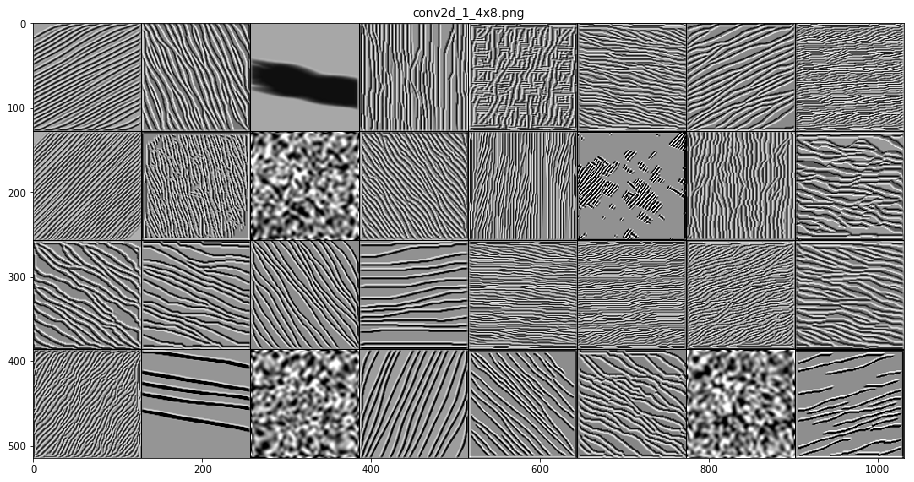

In [0]:
visualize_layer(model,"conv2d_1",filter_range=(0,32),upscaling_steps=20,
                    upscaling_factor=1.05,
                    output_dim=(128, 128),step=0.5,epochs=40)

Compute filters 0 to 32
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 32 filter processed.
Filter Losses:  [0.0, 21.638508, 8.894932, 8.458425, 11.446251, 4.3846154, 5.147071, 10.854166, 15.692328, 6.7814717, 17.856897, 0.0, 7.1439066, 5.2824936, 10.474015, 4.7056417, 4.71002, 5.5753765, 0.0, 7.5213504, 13.652573, 12.776076, 5.4264045, 0.0, 5.5027494, 6.087183, 8.899429, 13.176806, 13.290224, 0.0, 0.0, 6.354923]


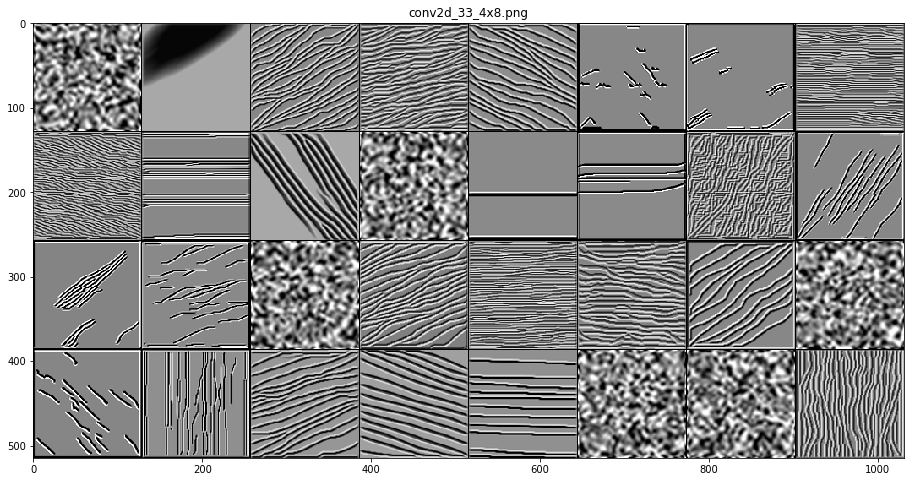

In [0]:
visualize_layer(model,"conv2d_33",filter_range=(0,32),upscaling_steps=20,
                    upscaling_factor=1.05,
                    output_dim=(128, 128),step=0.5,epochs=40)

Compute filters 0 to 16
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 16 filter processed.
Filter Losses:  [39.107243, 63.990356, 49.859188, 51.849964, 37.74104, 18.515785, 48.811695, 71.35533, 60.082504, 18.71733, 23.341259, 152.30362, 94.58888, 37.239292, 182.04561, 129.00554]


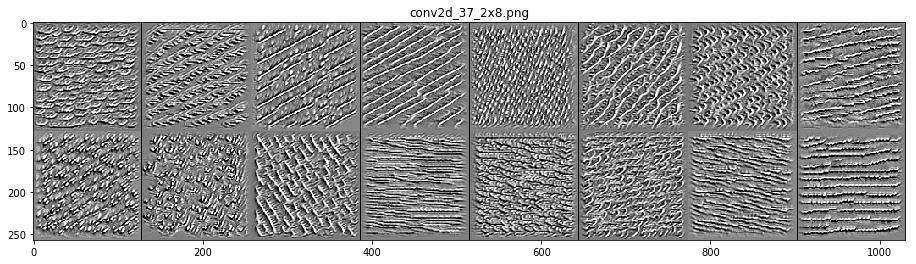

In [0]:
visualize_layer(model,"conv2d_37",filter_range=(0,16),upscaling_steps=20,
                    upscaling_factor=1.05,
                    output_dim=(128, 128),step=0.5,epochs=40)

### Without Custom Loss

In [0]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=20,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=60, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  12846

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_30', 'dropout_17', 'conv2d_31', 'conv2d_32', 'dropout_18', 'max_pooling2d_5', 'conv2d_33', 'dropout_19', 'conv2d_34', 'dropout_20', 'conv2d_35', 'dropout_21', 'conv2d_36', 'conv2d_37', 'flatten_5', 'activation_5']
Validation Loss (0.020222174975275994, 0.9937999999046325)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  12846
Score =  [0.004916046098697309, 0.9988833333333333]
Balanced Accuracy = 99.89% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-

## Architecture 4 [Selected]
- 8->16 architecture
- Low number of Params

### With Custom Loss

In [30]:

model = Sequential()

model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(8, 3,3, activation='relu')) # 10
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 6,6))



model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0002,verbose=0)
es = EarlyStopping("val_acc",patience=18,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss=combined_smoothness_diversity_loss(model,0.001,1e-5,0.1,0.0001,0.001),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=256, epochs=50, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.30% 99.25% 99.29%
# 99.28% 99.27%


Params =  10972
Layer Names:  ['conv2d_137', 'conv2d_138', 'dropout_83', 'max_pooling2d_19', 'conv2d_139', 'conv2d_140', 'dropout_84', 'conv2d_141', 'dropout_85', 'conv2d_142', 'dropout_86', 'conv2d_143', 'flatten_19', 'activation_19']
Validation Loss (0.025263074057735504, 0.9928)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.005229890970571432, 0.9987]
Balanced Accuracy = 99.87% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.025520113696716726, 0.9928]
Balanced Accuracy = 99.27% 


Decreasing regularization by dropouts since the number of kernels is very low here

In [31]:

model = Sequential()

model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(8, 3,3, activation='relu')) # 10
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 6,6))



model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0001,verbose=0)
es = EarlyStopping("val_acc",patience=18,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)

model.compile(loss=combined_smoothness_diversity_loss(model,0.001,1e-5,0.1,0.0001,0.001),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=256, epochs=50, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.46% 99.37% 99.34%
# 99.40% 99.43%


Params =  10972
Layer Names:  ['conv2d_144', 'conv2d_145', 'dropout_87', 'max_pooling2d_20', 'conv2d_146', 'conv2d_147', 'dropout_88', 'conv2d_148', 'dropout_89', 'conv2d_149', 'dropout_90', 'conv2d_150', 'flatten_20', 'activation_20']
Validation Loss (0.019952285717695487, 0.9941)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.003991547033200428, 0.9990166666666667]
Balanced Accuracy = 99.90% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.01978012078666361, 0.9944]
Balanced Accuracy = 99.43% 


Compute filters 0 to 8
  0   1   2   3   4   5   6   7 8 filter processed.
Filter Losses:  [14.373003, 28.105883, 10.480298, 9.335331, 11.475223, 11.9885645, 19.063118, 0.0]


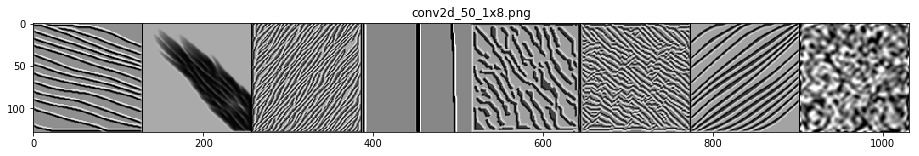

In [35]:
visualize_layer(model,"conv2d_50",filter_range=(0,8),upscaling_steps=20,
                    upscaling_factor=1.05,
                    output_dim=(128, 128),step=0.5,epochs=40)

### Without Custom Loss

In [0]:

model = Sequential()

model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(8, 3,3, activation='relu')) # 10
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 6,6))



model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0002,verbose=0)
es = EarlyStopping("val_acc",patience=18,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=256, epochs=50, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  10972
Layer Names:  ['conv2d_9', 'conv2d_10', 'dropout_6', 'max_pooling2d_2', 'conv2d_11', 'conv2d_12', 'dropout_7', 'conv2d_13', 'dropout_8', 'conv2d_14', 'dropout_9', 'conv2d_15', 'flatten_2', 'activation_2']
Validation Loss (0.026363362389057874, 0.9928)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.004035308052708933, 0.9989666666666667]
Balanced Accuracy = 99.90% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.025838754796626746, 0.9941]
Balanced Accuracy = 99.40% 


## Architecture 5 [Selected]


### With Custom Loss

In [30]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.2))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu')) #8
model.add(Convolution2D(10, 8,8))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0003,verbose=0)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)

model.compile(loss=combined_smoothness_diversity_loss(model,0.001,1e-5,0.1,0.0002,0.0005),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=256, epochs=80, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  11774
Layer Names:  ['conv2d_22', 'conv2d_23', 'dropout_13', 'max_pooling2d_4', 'conv2d_24', 'conv2d_25', 'dropout_14', 'conv2d_26', 'dropout_15', 'conv2d_27', 'conv2d_28', 'flatten_4', 'activation_4']
Validation Loss (0.023170175459235907, 0.9939)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  11774
Score =  [0.004746112709162601, 0.99895]
Balanced Accuracy = 99.89% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  11774
Score =  [0.022713979540555738, 0.9942]
Balanced Accuracy = 99.41% 


### Without Custom Loss

In [0]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.2))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu')) #8
model.add(Convolution2D(10, 8,8))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0003,verbose=0)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=256, epochs=80, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 99.19%

Params =  11774
Layer Names:  ['conv2d_52', 'conv2d_53', 'dropout_29', 'max_pooling2d_8', 'conv2d_54', 'conv2d_55', 'dropout_30', 'conv2d_56', 'dropout_31', 'conv2d_57', 'conv2d_58', 'flatten_8', 'activation_8']
Validation Loss (0.019324088820815086, 0.9938)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  11774
Score =  [0.005167050404912637, 0.9988666666666667]
Balanced Accuracy = 99.89% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  11774
Score =  [0.017673733695049303, 0.9944]
Balanced Accuracy = 99.43% 


## Architecture 14 [Selected]
Mixing MaxPool and Strides.
- We presume that MaxPool can be used in early part
- Towards the end we can use Strides=2 which prevents data loss which MaxPool causes, but reduces channel dimensions

### With Custom Loss

In [31]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(16, (3,3,),strides=2, activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #4
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())


reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0001,verbose=0)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss=combined_smoothness_diversity_loss(model,0.001,1e-5,0.1,0.0002,0.0005),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=128, epochs=80, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 99.26%

Params =  6974
Layer Names:  ['conv2d_29', 'conv2d_30', 'dropout_16', 'max_pooling2d_5', 'conv2d_31', 'dropout_17', 'conv2d_32', 'dropout_18', 'conv2d_33', 'dropout_19', 'conv2d_34', 'conv2d_35', 'flatten_5', 'activation_5']
Validation Loss (0.029186785835772753, 0.9912)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  6974
Score =  [0.012362427431359537, 0.9964333333333333]
Balanced Accuracy = 99.64% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  6974
Score =  [0.028449664580950048, 0.9916]
Balanced Accuracy = 99.15% 


### Without Custom Loss

In [0]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(16, (3,3,),strides=2, activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #4
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())


reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0001,verbose=0)
es = EarlyStopping("val_acc",patience=24,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=128, epochs=80, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)
# 98.89% -> 99.09% -> 99.25%

Params =  6974
Layer Names:  ['conv2d_45', 'conv2d_46', 'dropout_25', 'max_pooling2d_7', 'conv2d_47', 'dropout_26', 'conv2d_48', 'dropout_27', 'conv2d_49', 'dropout_28', 'conv2d_50', 'conv2d_51', 'flatten_7', 'activation_7']
Validation Loss (0.026417606200277804, 0.9921)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  6974
Score =  [0.011127139085830033, 0.9968]
Balanced Accuracy = 99.68% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  6974
Score =  [0.027304595174733548, 0.9929]
Balanced Accuracy = 99.28% 


# Misc Code

In [0]:
K.epsilon()

1e-07

In [0]:
layer = model.layers[0]
weights = layer.get_weights()[0]
len(weights)
weights.shape
print()
weights[:,:,:,0]

3

(3, 3, 1, 8)

array([[[-0.0850838 ],
        [-0.30148453],
        [-0.32764342]],

       [[-0.02206835],
        [ 0.42827725],
        [ 0.03842708]],

       [[ 0.05585115],
        [ 0.51634896],
        [ 0.3900442 ]]], dtype=float32)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 26, 26, 16)        1040      
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 22, 22, 16)        2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 9, 9, 16)          2320      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 7, 7, 32)          4640      
__________

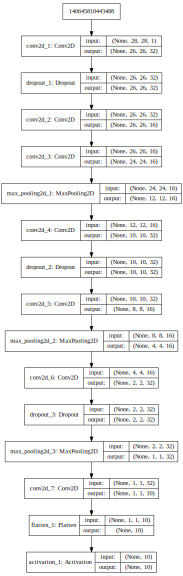

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('8x18')
SVG(m2d.create(prog='dot', format='svg'))